<a href="https://colab.research.google.com/github/maria-khoudary/NMA-project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# import libraries

import os
import json
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from joblib import load, dump 
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot

Using TensorFlow backend.


In [ ]:
# load Kay dataset

fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)

In [ ]:
# structure of dat, nvoxels per region
# dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
# for key in dat:
#   print(key)

In [ ]:
# preview images
# f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
# for ax, im in zip(axs.flat, dat["stimuli"]):
#   ax.imshow(im, cmap="gray")
# f.tight_layout()

In [ ]:
# visualize dat matrix
# f, ax = plt.subplots(figsize=(12, 5))
# ax.set(xlabel="Voxel", ylabel="Stimulus")
# heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
# f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
# f.tight_layout()

In [ ]:
# explore data values
# look at min & max pixel values in a sample image
# print(np.max(dat['stimuli'][0]))
# print(np.min(dat['stimuli'][0]))
# plt.imshow(dat['stimuli'][0])
# plt.colorbar()

# im_maxes = []
# im_mins = []
# for im in dat['stimuli']:
#   im_maxes.append(np.max(im))
#   im_mins.append(np.min(im))

# plt.hist(im_maxes)
# print('max maximum:', np.max(im_maxes))
# print('lowest maximum:', np.min(im_maxes))
# plt.hist(im_mins)
# print('highest min:', np.max(im_mins))
# print('lowest min:', np.min(im_mins))

# # look at min & maxes of BOLD signal
# plt.hist(dat['responses'][0])
# print(np.mean(dat['responses'][0]))
# print(np.std(dat['responses'][0]))
# # BOLD response is z-scored within a voxel 
# print(np.mean(dat['responses'][:,0]))
# print(np.std(dat['responses'][:,0]))

In [ ]:
# Helper Functions 

# normalize images
def normalize_images(image_set, norm_type='zero-to-one'):
  normed_images = np.zeros_like(image_set)
  if norm_type == 'zero-to-one':
    for ind, im in enumerate(image_set):
      normed_images[ind] = (im - np.min(im)) / (np.max(im) - np.min(im))
  normed_images = np.reshape(normed_images, (len(image_set), 128, 128, 1))
  
  return normed_images

# normalize BOLD output
def normalize_bold(bold_sig, norm_type='zero-to-one'):
  normed_bold = np.zeros_like(bold_sig)
  if norm_type == 'zero-to-one':
    for ind in range(bold_sig.shape[1]):
      sig = bold_sig[:,ind]
      normed_bold[:,ind] = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))  

  return normed_bold

# select input/output for specific ROI - input is ROI, output is training and test BOLD signals
def select_region_from_bold(region_names, dat = dat):
  responses, responses_test = dat['responses'], dat['responses_test']
  roi,roi_names = dat['roi'], dat['roi_names']

  bold_train_dict = {}
  bold_test_dict = {}

  for region_name in region_names:
    roi_number = np.where(roi_names == region_name)[0][0]
    bold_idx = np.where(roi_number == roi)[0]
    bold_train = responses[:,bold_idx]
    bold_test = responses_test[:,bold_idx]
    bold_train_dict[region_name] = bold_train
    bold_test_dict[region_name] = bold_test

  return bold_train_dict, bold_test_dict


def concat_data_wide_model(bold_train_dict, bold_test_dict):
  num_rows_train = len(list(bold_train_dict.values())[0])
  num_rows_test = len(list(bold_test_dict.values())[0])
  bold_train_array = np.zeros(shape = (num_rows_train, 0))
  bold_test_array = np.zeros(shape = (num_rows_test, 0))

  for key in bold_train_dict:
    value = bold_train_dict[key]
    bold_train_array = np.hstack((bold_train_array, value))

  for key in bold_test_dict:
    value = bold_test_dict[key]
    bold_test_array = np.hstack((bold_test_array, value))

  return bold_train_array, bold_test_array

In [ ]:
# custom callback to compute accuracy metric & stop based on validation accuracy
class custom_callback(keras.callbacks.Callback):
    def __init__(self, train_data,train_acc):
      self.train_data = train_data
      self.train_acc = train_acc
      self.max_acc = 0
      self.max_acc_weights = None
      self.patience = 4
      self.pat_counter = 0

    def on_epoch_end(self, epoch, logs):

      curr_acc = self.calculate_accuracy(self.validation_data)

      if self.train_acc:
        self.calculate_accuracy(self.train_data,data_set='train')

      if curr_acc > self.max_acc:
        self.max_acc = curr_acc
        self.max_acc_weights = self.model.get_weights()
        self.pat_counter = 0
      else:
        self.pat_counter += 1
        if self.pat_counter == self.patience:
          self.model.stop_training = True
          self.model.set_weights(self.max_acc_weights)

    # method to calculate classification accuracy for a given data set
    def calculate_accuracy(self, data, data_set='val'):
        images, true_bold = data[0], data[1]
        predicted_bold = self.model.predict(images)
        sum, lump_sum = 0, 0
        for pred_idx, score in enumerate(predicted_bold):
          corr_coefs = []
          for truth in true_bold: 
            corr, _ = pearsonr(score, truth)
            corr_coefs.append(corr)
          max_corr_idx = np.where(corr_coefs == np.max(corr_coefs))[0]
          if pred_idx in max_corr_idx:
            sum += 1 / len(max_corr_idx)
            lump_sum += 1
        accuracy = round(sum / len(images), 4)
        if data_set == 'val':
          print('Validation accuracy (Weighted) :', accuracy)
          print('Validation accuracy (Lump Sum) :', lump_sum,'/',len(images))
        elif data_set == 'train':
          print('Training accuracy (Weighted) :', accuracy)
          print('Training accuracy (Lump Sum) :', lump_sum,'/',len(images))

        return accuracy

In [ ]:
class NN_with_PCA_model(BaseEstimator, ClassifierMixin):

  def __init__(self, n_components=.99, NUM_FILTERS = 4, KERNEL_SIZE = 3, STRIDE_SIZE = 1, DROPOUT_RATE = .2,HIDDEN_LAYER_ACTIVATION ='relu',OUTPUT_ACTIVATION = None, LOSS_FUNCTION ='mse', CALCULATE_TRAIN_ACC = False, NUM_EPOCHS = 100, IMAGE_SIZE = len(dat['stimuli'][0]), REGION = 'V1', TEST_SET_PROPORTION = 0.1):
      
      # nn model
      self.model = None

      # for PCA
      self.n_components = n_components
      self.pca = PCA()

      # hyperparameters
      self.NUM_FILTERS = NUM_FILTERS
      self.KERNEL_SIZE = KERNEL_SIZE
      self.STRIDE_SIZE = STRIDE_SIZE
      self.DROPOUT_RATE = DROPOUT_RATE
      self.HIDDEN_LAYER_ACTIVATION = HIDDEN_LAYER_ACTIVATION
      self.OUTPUT_ACTIVATION = OUTPUT_ACTIVATION
      self.LOSS_FUNCTION = LOSS_FUNCTION
      self.CALCULATE_TRAIN_ACC = CALCULATE_TRAIN_ACC
      self.NUM_EPOCHS = NUM_EPOCHS
      self.IMAGE_SIZE = IMAGE_SIZE
      self.REGION = REGION
      self.TEST_SET_PROPORTION = TEST_SET_PROPORTION

  def defineandcompile_model(self, output_nodes):
      model = Sequential(name=self.REGION)
      model.add(Conv2D(filters=self.NUM_FILTERS, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Flatten())
      model.add(Dropout(self.DROPOUT_RATE))
      model.add(Dense(output_nodes, activation=self.OUTPUT_ACTIVATION))
      model.compile(optimizer='adam',loss=self.LOSS_FUNCTION)
      print('var explained:', self.n_components)
      print(model.summary())

      return model

  def fit(self, X, y):
      self.pca.n_components = self.n_components
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.TEST_SET_PROPORTION)
      y_train = self.pca.fit_transform(y_train)
      self.model = self.defineandcompile_model(y_train.shape[1])
      y_val = self.pca.transform(y_val)
      accuracy_callback = custom_callback((X_train, y_train),train_acc=self.CALCULATE_TRAIN_ACC)
      es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)
      self.model.fit(X_train, y_train, epochs=self.NUM_EPOCHS, callbacks=[accuracy_callback, es], validation_data=(X_val, y_val))
      
      return self

  def predict(self, X):
      return self.model.predict(X)

  def score(self, X, y):
    correct_idx = []
    images, true_bold = X, y
    true_bold = self.pca.transform(true_bold)
    predicted_bold = self.predict(X)    
    sum, lump_sum = 0, 0
    for pred_idx, score in enumerate(predicted_bold):
      corr_coefs = []
      for truth in true_bold: 
        corr, _ = pearsonr(score, truth)
        corr_coefs.append(corr)
      max_corr_idx = np.where(corr_coefs == np.max(corr_coefs))[0]
      if pred_idx in max_corr_idx:
        correct_idx.append(pred_idx)
        sum += 1 / len(max_corr_idx)
        lump_sum += 1
    accuracy = round(sum / len(images), 4)
    print('lump sum:', lump_sum)
    print('correctly identified images:', correct_idx)
    return accuracy
    


In [ ]:
# Constants
# TEST_SET_PROPORTION = .2
REGION = ['V1', 'V2', 'V3']

# get train bold signal for specific region
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
bold_train, _  = concat_data_wide_model(bold_train_dict, bold_test_dict)

# normalize input images
normed_images = normalize_images(dat['stimuli'])

In [ ]:
# run CV to find best hyperparamters 
EXPLAINED_VARIANCES = [0.95]
NUM_FILTERS = [22]

# parameter dictionary for grid search
param_grid = {'n_components': EXPLAINED_VARIANCES, 'NUM_FILTERS': NUM_FILTERS}
#param_grid = {'n_components': EXPLAINED_VARIANCES}

# instantiate Neural Net with PCA object
neural_net = NN_with_PCA_model()

# instantiate train val split object
cv = ShuffleSplit(n_splits=1, test_size=TEST_SET_PROPORTION, random_state=0)

# instantiate grid search object
K = 2
search = GridSearchCV(neural_net, param_grid, cv=K)

# run the model
search.fit(normed_images, bold_train)
dump(search, '/content/drive/My Drive/Gabor filter group project/models/V3_wide_model.joblib')

In [ ]:
# get weights for first hidden layer
model = load('/content/drive/My Drive/Gabor filter group project/models/V1_model.joblib')
V1_weights = model.best_estimator_.model.get_weights()
V1_filter_weights = V1_weights[0]
V1_filter_biases = V1_weights[1]

# DEEP MODEL 
class NN_with_PCA_model_deep(BaseEstimator, ClassifierMixin):

  def __init__(self, n_components=.99, NUM_FILTERS_1 = 30, NUM_FILTERS_2 = 16, KERNEL_SIZE = 3, STRIDE_SIZE = 1, DROPOUT_RATE = .2,HIDDEN_LAYER_ACTIVATION ='relu',OUTPUT_ACTIVATION = None, LOSS_FUNCTION ='mse', CALCULATE_TRAIN_ACC = False, NUM_EPOCHS = 100, IMAGE_SIZE = len(dat['stimuli'][0]), REGION = 'V1', TEST_SET_PROPORTION = 0.1, V1_FILTER_WEIGHTS = V1_filter_weights, V1_FILTER_BIASES = V1_filter_biases):
      
      # nn model
      self.model = None

      # for PCA
      self.n_components = n_components
      self.pca = PCA()

      # hyperparameters
      self.NUM_FILTERS_1 = NUM_FILTERS_1
      self.NUM_FILTERS_2 = NUM_FILTERS_2
      self.KERNEL_SIZE = KERNEL_SIZE
      self.STRIDE_SIZE = STRIDE_SIZE
      self.DROPOUT_RATE = DROPOUT_RATE
      self.HIDDEN_LAYER_ACTIVATION = HIDDEN_LAYER_ACTIVATION
      self.OUTPUT_ACTIVATION = OUTPUT_ACTIVATION
      self.LOSS_FUNCTION = LOSS_FUNCTION
      self.CALCULATE_TRAIN_ACC = CALCULATE_TRAIN_ACC
      self.NUM_EPOCHS = NUM_EPOCHS
      self.IMAGE_SIZE = IMAGE_SIZE
      self.REGION = REGION
      self.TEST_SET_PROPORTION = TEST_SET_PROPORTION
      self.V1_FILTER_WEIGHTS = V1_FILTER_WEIGHTS
      self.V1_FILTER_BIASES = V1_FILTER_BIASES

  def defineandcompile_model(self, output_nodes):
      print(self.NUM_FILTERS_1)
      print(self.NUM_FILTERS_2)
      model = Sequential(name=self.REGION)
      model.add(Conv2D(filters=self.NUM_FILTERS_1, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Conv2D(filters=self.NUM_FILTERS_2, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Flatten())
      model.add(Dropout(self.DROPOUT_RATE))
      model.add(Dense(output_nodes, activation=self.OUTPUT_ACTIVATION))
      print('var explained:', self.n_components)
      print(model.summary())
      print(self.V2_FILTER_WEIGHTS.shape)
      print(self.V2_FILTER_BIASES.shape)

      model.layers[0].set_weights([self.V1_FILTER_WEIGHTS, self.V1_FILTER_BIASES]) 
      model.layers[0].trainable = False

      model.compile(optimizer='adam',loss=self.LOSS_FUNCTION)

      return model
      

  def fit(self, X, y):
      self.pca.n_components = self.n_components
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.TEST_SET_PROPORTION)
      y_train = self.pca.fit_transform(y_train)
      self.model = self.defineandcompile_model(y_train.shape[1])
      y_val = self.pca.transform(y_val)
      accuracy_callback = custom_callback((X_train, y_train),train_acc=self.CALCULATE_TRAIN_ACC)
      self.model.fit(X_train, y_train, epochs=self.NUM_EPOCHS, callbacks=[accuracy_callback], validation_data=(X_val, y_val))
      
      return self

  def predict(self, X):
      return self.model.predict(X)

  def score(self, X, y):
    correct_idx = []
    images, true_bold = X, y
    true_bold = self.pca.transform(true_bold)
    predicted_bold = self.predict(X)    
    sum, lump_sum = 0, 0
    for pred_idx, score in enumerate(predicted_bold):
      corr_coefs = []
      for truth in true_bold: 
        corr, _ = pearsonr(score, truth)
        corr_coefs.append(corr)
      max_corr_idx = np.where(corr_coefs == np.max(corr_coefs))[0]
      if pred_idx in max_corr_idx:
        correct_idx.append(pred_idx)
        sum += 1 / len(max_corr_idx)
        lump_sum += 1
    accuracy = round(sum / len(images), 4)
    print('correctly identified images:', correct_idx)
    return accuracy


In [ ]:
# Constants
normed_images_train = normalize_images(dat['stimuli'])
TEST_SET_PROPORTION = .2
REGION = ['V2']

# get train bold signal for specific region
V2_bold_train_dict, V2_bold_test_dict = select_region_from_bold(REGION, dat)
V2_bold_train, V2_bold_test = concat_data_wide_model(V2_bold_train_dict, V2_bold_test_dict)

# run CV to find best hyperparamters 
EXPLAINED_VARIANCES = np.arange(0.5, 1, 0.2)
NUM_FILTERS_3 = np.arange(2,16,2)

# parameter dictionary for grid search
param_grid = {'n_components': EXPLAINED_VARIANCES, 'NUM_FILTERS_3': NUM_FILTERS_3}

# instantiate Neural Net with PCA object
neural_net = NN_with_PCA_model_deep()

# instantiate train val split object
cv = ShuffleSplit(n_splits=1, test_size=TEST_SET_PROPORTION, random_state=0)

# instantiate grid search object
K = 2
search = GridSearchCV(neural_net, param_grid, cv=K)

# run the model
search.fit(normed_images_train, V2_bold_train)
dump(search, '/content/drive/My Drive/Gabor filter group project/models/V2_deep.joblib')

ValueError: ignored

In [ ]:
# DEEP MODEL V3
# get V2 weights
V2_deep = load('/content/drive/My Drive/Gabor filter group project/models/V2_deep.joblib')
V2_deep_weights = V2_deep.best_estimator_.model.get_weights()

V2_deep_filter_weights = V2_deep_weights[2]
V2_deep_filter_biases = V2_deep_weights[3]

# create class
class NN_with_PCA_model_V3_deep(BaseEstimator, ClassifierMixin):

  def __init__(self, n_components=.99, NUM_FILTERS_1 = 30, NUM_FILTERS_2 = 16, NUM_FILTERS_3=8, KERNEL_SIZE = 3, STRIDE_SIZE = 1, DROPOUT_RATE = .2,HIDDEN_LAYER_ACTIVATION ='relu',OUTPUT_ACTIVATION = None, LOSS_FUNCTION ='mse', CALCULATE_TRAIN_ACC = False, NUM_EPOCHS = 100, IMAGE_SIZE = len(dat['stimuli'][0]), REGION = 'V1', TEST_SET_PROPORTION = 0.1, V1_FILTER_WEIGHTS = V1_filter_weights, V1_FILTER_BIASES = V1_filter_biases, V2_FILTER_WEIGHTS = V2_deep_filter_weights, V2_FILTER_BIASES = V2_deep_filter_biases):
      
      # nn model
      self.model = None

      # for PCA
      self.n_components = n_components
      self.pca = PCA()

      # hyperparameters
      self.NUM_FILTERS_1 = NUM_FILTERS_1
      self.NUM_FILTERS_2 = NUM_FILTERS_2
      self.NUM_FILTERS_3 = NUM_FILTERS_3
      self.KERNEL_SIZE = KERNEL_SIZE
      self.STRIDE_SIZE = STRIDE_SIZE
      self.DROPOUT_RATE = DROPOUT_RATE
      self.HIDDEN_LAYER_ACTIVATION = HIDDEN_LAYER_ACTIVATION
      self.OUTPUT_ACTIVATION = OUTPUT_ACTIVATION
      self.LOSS_FUNCTION = LOSS_FUNCTION
      self.CALCULATE_TRAIN_ACC = CALCULATE_TRAIN_ACC
      self.NUM_EPOCHS = NUM_EPOCHS
      self.IMAGE_SIZE = IMAGE_SIZE
      self.REGION = REGION
      self.TEST_SET_PROPORTION = TEST_SET_PROPORTION
      self.V1_FILTER_WEIGHTS = V1_FILTER_WEIGHTS
      self.V1_FILTER_BIASES = V1_FILTER_BIASES
      self.V2_FILTER_WEIGHTS = V2_FILTER_WEIGHTS 
      self.V2_FILTER_BIASES = V2_FILTER_BIASES

  def defineandcompile_model(self, output_nodes):
      print(self.NUM_FILTERS_1)
      print(self.NUM_FILTERS_2)
      model = Sequential(name=self.REGION)
      model.add(Conv2D(filters=self.NUM_FILTERS_1, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Conv2D(filters=self.NUM_FILTERS_2, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Conv2D(filters=self.NUM_FILTERS_3, 
                       kernel_size=self.KERNEL_SIZE, 
                       strides=self.STRIDE_SIZE, 
                       activation=self.HIDDEN_LAYER_ACTIVATION, 
                       input_shape=(self.IMAGE_SIZE,self.IMAGE_SIZE,1)))
      model.add(MaxPooling2D())
      model.add(Flatten())
      model.add(Dropout(self.DROPOUT_RATE))
      model.add(Dense(output_nodes, activation=self.OUTPUT_ACTIVATION))
      print('var explained:', self.n_components)
      print(model.summary())
      print(self.V2_FILTER_WEIGHTS.shape)
      print(self.V2_FILTER_BIASES.shape)

      model.layers[0].set_weights([self.V1_FILTER_WEIGHTS, self.V1_FILTER_BIASES]) 
      model.layers[2].set_weights([self.V2_FILTER_WEIGHTS, self.V2_FILTER_BIASES]) 
      model.layers[0].trainable = False
      model.layers[2].trainable = False

      model.compile(optimizer='adam',loss=self.LOSS_FUNCTION)

      return model
      

  def fit(self, X, y):
      self.pca.n_components = self.n_components
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.TEST_SET_PROPORTION)
      y_train = self.pca.fit_transform(y_train)
      self.model = self.defineandcompile_model(y_train.shape[1])
      y_val = self.pca.transform(y_val)
      accuracy_callback = custom_callback((X_train, y_train),train_acc=self.CALCULATE_TRAIN_ACC)
      self.model.fit(X_train, y_train, epochs=self.NUM_EPOCHS, callbacks=[accuracy_callback], validation_data=(X_val, y_val))
      
      return self

  def predict(self, X):
      return self.model.predict(X)

  def score(self, X, y):
    correct_idx = []
    images, true_bold = X, y
    true_bold = self.pca.transform(true_bold)
    predicted_bold = self.predict(X)    
    sum, lump_sum = 0, 0
    for pred_idx, score in enumerate(predicted_bold):
      corr_coefs = []
      for truth in true_bold: 
        corr, _ = pearsonr(score, truth)
        corr_coefs.append(corr)
      max_corr_idx = np.where(corr_coefs == np.max(corr_coefs))[0]
      if pred_idx in max_corr_idx:
        correct_idx.append(pred_idx)
        sum += 1 / len(max_corr_idx)
        lump_sum += 1
    accuracy = round(sum / len(images), 4)
    print('correctly identified images:', correct_idx)
    return accuracy


In [ ]:
TEST_SET_PROPORTION = .2
REGION = ['V3']

# get train bold signal for specific region
V3_bold_train_dict, V3_bold_test_dict = select_region_from_bold(REGION, dat)
V3_bold_train, _ = concat_data_wide_model(V3_bold_train_dict, V3_bold_test_dict)

# run CV to find best hyperparamters 
EXPLAINED_VARIANCES = np.arange(0.5, 1, 0.2)
NUM_FILTERS_3 = np.arange(4,24,4)

# parameter dictionary for grid search
param_grid = {'n_components': EXPLAINED_VARIANCES, 'NUM_FILTERS_3': NUM_FILTERS_3}

# instantiate Neural Net with PCA object
neural_net = NN_with_PCA_model_V3_deep()

# instantiate train val split object
cv = ShuffleSplit(n_splits=1, test_size=TEST_SET_PROPORTION, random_state=0)

# instantiate grid search object
K = 5
search = GridSearchCV(neural_net, param_grid, cv=K)

# run the model
search.fit(normed_images_train, V3_bold_train)
dump(search, '/content/drive/My Drive/Gabor filter group project/models/V3_deep.joblib')

KeyboardInterrupt: ignored

In [ ]:
# prep for plotting feature maps
V2_wide_model = load('/content/drive/My Drive/Gabor filter group project/models/V2_wide_model.joblib')
V2_wide_model.best_score_
V2_wide_weights = V2_wide_model.best_estimator_.model.get_weights()
V2_wide_filter_weights = V2_wide_weights[0]
V2_wide_filter_biases = V2_wide_weights[1]

V3_wide_model = load('/content/drive/My Drive/Gabor filter group project/models/V3_wide_model.joblib')
V3_wide_model.best_score_
V3_wide_weights = V3_wide_model.best_estimator_.model.get_weights()
V3_wide_filter_weights = V3_wide_weights[0]
V3_wide_filter_biases = V3_wide_weights[1]

V2_deep = load('/content/drive/My Drive/Gabor filter group project/models/V2_deep.joblib')
V2_deep_weights = V2_deep.best_estimator_.model.get_weights()
V2_deep_filter_weights = V2_deep_weights[2]
V2_deep_filter_biases = V2_deep_weights[3]
print(V2_deep_filter_weights.shape)
print(V2_deep_filter_biases.shape)

V3_deep = load('/content/drive/My Drive/Gabor filter group project/models/V3_deep.joblib')
V3_deep_weights = V3_deep.best_estimator_.model.get_weights()
V3_deep_filter_weights = V3_deep_weights[4]
V3_deep_filter_biases = V3_deep_weights[5]

(3, 3, 30, 16)
(16,)


In [ ]:
# Function for feature maps
def plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, 
                      layer_idx, V1_FILTER_WEIGHTS = V1_filter_weights, V1_FILTER_BIASES = V1_filter_biases,
                      V2_FILTER_WEIGHTS = V2_deep_filter_weights, V2_FILTER_BIASES = V2_deep_filter_biases):
  # constants
  KERNEL_SIZE = 3
  STRIDE_SIZE = 1 
  HIDDEN_LAYER_ACTIVATION ='relu'
  LOSS_FUNCTION ='mse'
  IMAGE_SIZE = len(dat['stimuli'][0])

  # compile model
  model = Sequential(name=REGION)
  
  if layer_idx == 0:
    model.add(Conv2D(filters=NUM_FILTERS, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.layers[layer_idx].set_weights([FILTER_WEIGHTS, FILTER_BIASES]) 
  elif layer_idx == 2: 
    model.add(Conv2D(filters=30, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=NUM_FILTERS, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.layers[0].set_weights([V1_FILTER_WEIGHTS, V1_FILTER_BIASES]) 
    model.layers[layer_idx].set_weights([FILTER_WEIGHTS, FILTER_BIASES]) 
  else:
    model.add(Conv2D(filters=30, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=16, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=NUM_FILTERS, 
                    kernel_size=KERNEL_SIZE, 
                    strides=STRIDE_SIZE, 
                    activation=HIDDEN_LAYER_ACTIVATION, 
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.layers[0].set_weights([V1_FILTER_WEIGHTS, V1_FILTER_BIASES]) 
    model.layers[2].set_weights([V2_FILTER_WEIGHTS, V2_FILTER_BIASES]) 
    model.layers[layer_idx].set_weights([FILTER_WEIGHTS, FILTER_BIASES]) 

  model.compile(optimizer='adam',loss=LOSS_FUNCTION)

  # display input image
  feature_maps = model.predict(normed_images[image_idx].reshape((1, 128, 128, 1)))
  print(feature_maps.shape)
  plt.imshow(normed_images[image_idx,:,:,0], cmap = 'gray')

  # display feature maps
  fig=plt.figure(figsize=(6, 5))
  columns = 6
  rows = 5
  for i in range(NUM_FILTERS):
      img = feature_maps[0,:,:,i]
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img, cmap = 'gray')
  plt.show()  

In [ ]:
## Test models
# get images
normed_images_test = normalize_images(dat['stimuli_test'])

### V1 ###
REGION = ['V1']
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
_, bold_test = concat_data_wide_model(bold_train_dict, bold_test_dict)
V1_model = load('/content/drive/My Drive/Gabor filter group project/models/V1_model.joblib')
print('V1 results:')
V1_prediction = V1_model.predict(normed_images_test)
print('Shape:', V1_prediction.shape)
V1_test_accuracy = V1_model.score(normed_images_test, bold_test)
print('Accuracy',V1_test_accuracy, "\n\n")

### V2 WIDE ###
REGION = ['V1', 'V2']
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
_, bold_test = concat_data_wide_model(bold_train_dict, bold_test_dict)
V2_wide_model = load('/content/drive/My Drive/Gabor filter group project/models/V2_wide_model.joblib')
print('V2 wide results:')
V2_wide_prediction = V2_wide_model.predict(normed_images_test)
print('Shape:', V2_wide_prediction.shape)
V2_wide_accuracy = V2_wide_model.score(normed_images_test, bold_test)
print('Accuracy', V2_wide_accuracy, "\n\n")

### V3 WIDE ###
REGION = ['V1', 'V2', 'V3']
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
_, bold_test = concat_data_wide_model(bold_train_dict, bold_test_dict)
V3_wide_model = load('/content/drive/My Drive/Gabor filter group project/models/V3_wide_model.joblib')
print('V3 wide results:')
V3_wide_prediction = V3_wide_model.predict(normed_images_test)
print('Shape:', V3_wide_prediction.shape)
V3_wide_accuracy = V3_wide_model.score(normed_images_test, bold_test)
print('Accuracy', V3_wide_accuracy, "\n\n")

### V2 DEEP ###
REGION = ['V2']
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
_, bold_test = concat_data_wide_model(bold_train_dict, bold_test_dict)
V2_deep_model = load('/content/drive/My Drive/Gabor filter group project/models/V2_deep.joblib')
print('V2 deep results:')
V2_deep_prediction = V2_deep_model.predict(normed_images_test)
print('Shape:', V2_deep_prediction.shape)
V2_deep_accuracy = V2_deep_model.score(normed_images_test, bold_test)
print('Accuracy', V2_deep_accuracy, "\n\n")

### V3 DEEP ###
REGION = ['V3']
bold_train_dict, bold_test_dict = select_region_from_bold(REGION, dat)
_, bold_test = concat_data_wide_model(bold_train_dict, bold_test_dict)
V3_deep_model = load('/content/drive/My Drive/Gabor filter group project/models/V3_deep.joblib')
print('V3 deep results:')
V3_deep_prediction = V3_deep_model.predict(normed_images_test)
print('Shape:', V3_deep_prediction.shape)
V3_deep_accuracy = V3_deep_model.score(normed_images_test, bold_test)
print('Accuracy', V3_deep_accuracy, "\n\n", 'We did it!')

V1 results:
Shape: (120, 245)
lump sum: 38
correctly identified images: [11, 12, 16, 17, 19, 20, 28, 30, 34, 37, 40, 41, 48, 49, 53, 56, 57, 66, 70, 72, 74, 77, 81, 83, 85, 90, 91, 92, 94, 100, 102, 103, 106, 110, 112, 114, 118, 119]
Accuracy 0.3167 




KeyboardInterrupt: ignored

In [ ]:
V1_corr = {11, 12, 16, 17, 19, 20, 28, 30, 34, 37, 40, 41, 48, 49, 53, 56, 57, 66, 70, 72, 74, 77, 81, 83, 85, 90, 91, 92, 94, 100, 102, 103, 106, 110, 112, 114, 118, 119}
V2_wide_corr = {41, 70, 91}
V3_wide_corr = {18, 41, 81, 84, 85, 86, 87, 90, 91, 92, 102}
V2_deep_corr = {1, 2, 5, 12, 17, 20, 28, 30, 32, 40, 48, 50, 52, 53, 57, 61, 70, 80, 81, 87, 90, 91, 92, 94, 100, 102, 112}
V3_deep_corr = {5, 9, 12, 21, 24, 48, 57, 79, 80, 85, 87, 90, 92, 94, 102}

wide_corrs = V2_wide_corr.intersection(V3_wide_corr)
V1_wide_corrs = V1_corr.intersection(V2_wide_corr.intersection(V3_wide_corr))
print('wide corrs: ', wide_corrs)
print('V1 wide corrs: ', V1_wide_corrs) 
deep_corrs = V2_deep_corr.intersection(V3_deep_corr)
V1_deep_corrs = V1_corr.intersection(V2_deep_corr.intersection(V3_deep_corr))
print('deep corrs: ', deep_corrs)
print('V1 deep corrs: ', V1_deep_corrs)

wide corrs:  {41, 91}
V1 wide corrs:  {41, 91}
deep corrs:  {5, 102, 12, 48, 80, 87, 57, 90, 92, 94}
V1 deep corrs:  {102, 12, 48, 57, 90, 92, 94}


(1, 126, 126, 30)


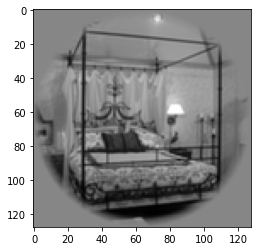

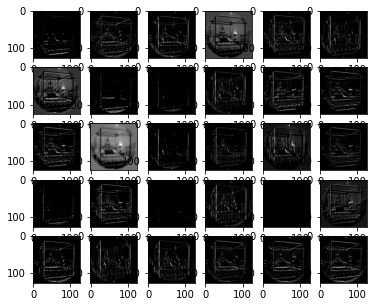

(1, 126, 126, 26)


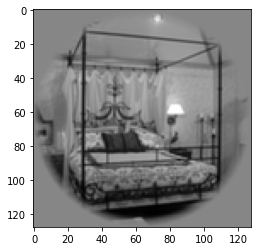

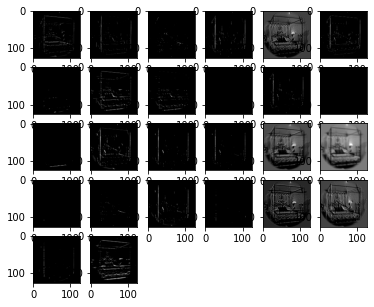

(1, 126, 126, 22)


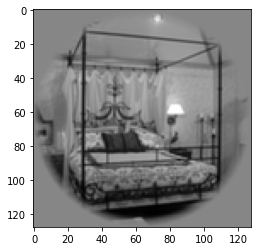

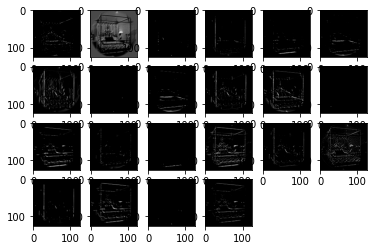

(1, 61, 61, 16)


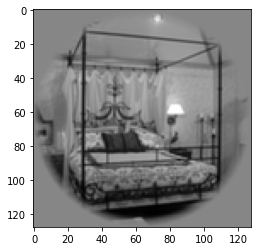

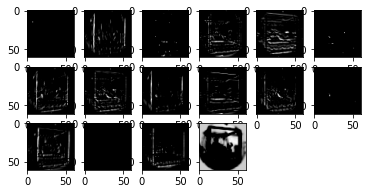

(3, 3, 16, 16)
(1, 28, 28, 16)


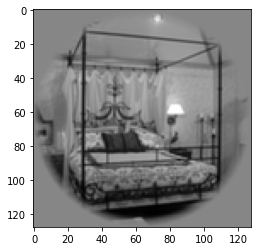

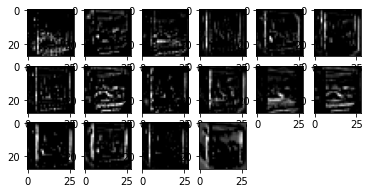

In [ ]:
# Create feature maps
# constants
image_idx = 70

# V1 model
NUM_FILTERS = 30
REGION = 'V1'
FILTER_WEIGHTS = V1_filter_weights 
FILTER_BIASES = V1_filter_biases
layer_idx = 0
plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, layer_idx)

# V2 wide model
NUM_FILTERS = 26
REGION = 'V2'
FILTER_WEIGHTS = V2_wide_filter_weights 
FILTER_BIASES = V2_wide_filter_biases
layer_idx = 0
plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, layer_idx)

# V3 wide model
NUM_FILTERS = 22
REGION = 'V3'
FILTER_WEIGHTS = V3_wide_filter_weights 
FILTER_BIASES = V3_wide_filter_biases
layer_idx = 0
plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, layer_idx)

# V2 deep model
NUM_FILTERS = 16
REGION = 'V2'
FILTER_WEIGHTS = V2_deep_filter_weights 
FILTER_BIASES = V2_deep_filter_biases
layer_idx = 2
plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, layer_idx)

# # V3 deep model
NUM_FILTERS = 16
REGION = 'V3'
FILTER_WEIGHTS = V3_deep_filter_weights 
print(V3_deep_filter_weights.shape)
FILTER_BIASES = V3_deep_filter_biases
layer_idx = 4
plot_feature_maps(NUM_FILTERS, REGION, FILTER_WEIGHTS, FILTER_BIASES, image_idx, layer_idx)

In [ ]:
# Model dictionaries (get standard error)

# V1
print('V1: ')
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V1_dict_1.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print('\n')

# V2 wide
print('V2 wide: ')
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V1V2_wide_1.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V1V2_wide_2.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print('\n')

# V3 wide
print('V3 wide: ')
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V1V2V3_wide.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V1V2V3_wide_2.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print('\n')

# V2 deep
print('V2 deep: ')
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V2_deep_1.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
V1_dict_1 = np.load('/content/drive/My Drive/Gabor filter group project/model_dicts/V2_deep_2.npy', allow_pickle = True)[()]
print(V1_dict_1['std_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print(V1_dict_1['mean_test_score'][np.argmin(V1_dict_1['rank_test_score'])])
print('\n')

# # V3 deep
V3_deep.best_params_
V3_train_mean = V3_deep.cv_results_['mean_test_score'][10]*100
V3_train_std = V3_deep.cv_results_['std_test_score'][10]*100

V1: 
0.021607646794595654
0.10286


V2 wide: 
0.020169025757333942
0.11602000000000001
0.02512818338041969
0.11602


V3 wide: 
0.021866997964969954
0.10228000000000001
0.024326693157928393
0.09770000000000001


V2 deep: 
0.01668261370409325
0.10057999999999999
0.016625835317360747
0.09314




(0.0, 35.0)

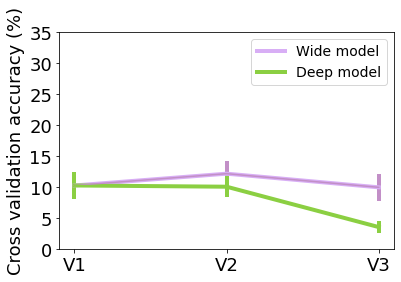

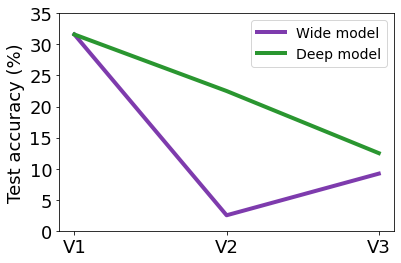

In [ ]:
# Making some nice plots

# Train plots
plt.figure()

wide_x = [1, 2, 3]
wide_y = [10.3, 12.2, 10]
wide_std = [2.16, 2.0169, 2.187]

deep_x = [1, 2, 3]
deep_y = [10.3, 10.1, V3_train_mean]
deep_std = [2.16, 1.66, V3_train_std] 

plt.plot(wide_x, wide_y, c='#d8aef5',linewidth=4)
plt.plot(deep_x, deep_y, c='#8bcf42', linewidth=4)
plt.errorbar(wide_x, wide_y, wide_std, color='#c28fc7', elinewidth=4) 
plt.errorbar(deep_x, deep_y, deep_std, color='#8bcf42', elinewidth=4)
plt.ylabel('Cross validation accuracy (%)', fontsize=18)

plt.legend(['Wide model', 'Deep model'], fontsize=14)
plt.xticks(ticks = [1, 2, 3], labels = ['V1', 'V2', 'V3'], fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 35)

plt.figure()

# Test plots
wide_x = [1, 2, 3]
wide_y = [31.6, 2.5, 9.2]

deep_x = [1, 2, 3]
deep_y = [31.6, 22.5, 12.5]

plt.plot(wide_x, wide_y, color='#7e3bad', linewidth=4)
plt.plot(deep_x, deep_y, color='#2a9630', linewidth=4)
plt.ylabel('Test accuracy (%)', fontsize=18)

plt.legend(['Wide model', 'Deep model'], fontsize=14)
plt.xticks(ticks = [1, 2, 3], labels = ['V1', 'V2', 'V3'], fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(0, 35)